In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("..")

from config.config import Config

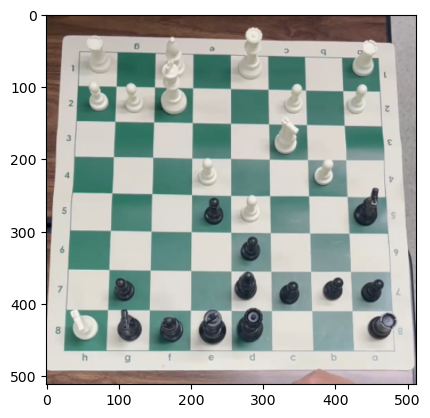

In [2]:
img = cv2.imread(Config.IMAGE_DIR / "test" / "chess4.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, Config.IMAGE_SIZE, interpolation=cv2.INTER_LINEAR)

plt.imshow(img)

In [4]:
def cannyPF(img, sigma=0.25):
    med = np.median(img)
    lower = int(max(0, (1.0 - sigma) * med))
    upper = int(min(255, (1.0 + sigma) * med))
    return cv2.Canny(img, lower, upper)

gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

bilateral = cv2.bilateralFilter(gray, d=(Config.BILATERAL_FILTER_DIAMETER), sigmaColor=75, sigmaSpace=75)

canny = cannyPF(bilateral, sigma=0.33)

lines = cv2.HoughLines(canny, 1, np.pi/720.0, 50, np.array([]), 0, 0)
lines_best = np.squeeze(lines)[:100]

In [5]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Normalize features (rho and theta have different scales)
scaler = StandardScaler()
lines_normalized = scaler.fit_transform(lines_best)

# Cluster similar lines
clustering = DBSCAN(eps=0.05, min_samples=2).fit(lines_normalized)
labels = clustering.labels_

# Average lines within each cluster
unique_lines = []
for label in set(labels):
    if label != -1:  # Not noise
        cluster_lines = lines_best[labels == label]
        avg_rho = np.mean(cluster_lines[:, 0])
        avg_theta = np.mean(cluster_lines[:, 1])
        unique_lines.append([avg_rho, avg_theta])

In [6]:
group1, group2 = [], []
temp_group = []
group1_mean, group2_mean = None, None

for i, (rho, theta) in enumerate(unique_lines):
  if group1_mean is None:
    if theta >=np.pi/3 and theta <= 2*np.pi/3:
      group1.append(i)
      group1_mean = theta
    else:
      temp_group.append(i)
  else:
    diff = abs(theta - group1_mean) 
    if diff <= np.pi/3:
      group1.append(i)
      group1_mean = np.mean([unique_lines[j][1] for j in group1])
    else:
      temp_group.append(i)

for i in temp_group:
  rho, theta = unique_lines[i]
  diff = abs(theta - group1_mean)
  if diff > np.pi/3:
    group2.append(i)
    if group2_mean is None:
      group2_mean = theta
    else:
      group2_mean = np.mean([unique_lines[j][1] for j in group2])
  else:
    group1.append(i)
    group1_mean = np.mean([unique_lines[j][1] for j in group1])

In [7]:
import itertools

def select_best_9_lines(group_indices, unique_lines):
    """Select 9 lines with most uniform spacing"""
    
    # Extract lines and sort by rho (handle negative rho)
    lines_with_idx = [(i, unique_lines[i][0], unique_lines[i][1]) for i in group_indices]
    
    # Normalize: if rho < 0, flip to positive and adjust theta
    normalized = []
    for idx, rho, theta in lines_with_idx:
        if rho < 0:
            rho = -rho
            theta = theta + np.pi if theta < np.pi else theta - np.pi
        normalized.append((idx, rho, theta))
    
    # Sort by rho
    normalized.sort(key=lambda x: x[1])
    sorted_indices = [x[0] for x in normalized]
    sorted_rhos = [x[1] for x in normalized]
    
    if len(sorted_indices) <= 9:
        return sorted_indices
    
    # Try all combinations
    best_indices = None
    best_score = float('inf')
    
    for combo in itertools.combinations(range(len(sorted_indices)), 9):
        combo_rhos = [sorted_rhos[i] for i in combo]
        
        # Linear fit
        x = np.arange(9)
        poly_coeffs = np.polyfit(x, combo_rhos, deg=2)
        predicted = np.polyval(poly_coeffs, x)
        mse = np.mean((combo_rhos - predicted) ** 2)
        
        if mse < best_score:
            best_score = mse
            best_indices = [sorted_indices[i] for i in combo]
    
    return best_indices

# Select best 9 lines from each group
print("Selecting best 9 lines from Group 1...")
best_group1 = select_best_9_lines(group1, unique_lines)
print("Selecting best 9 lines from Group 2...")
best_group2 = select_best_9_lines(group2, unique_lines)

print(f"\nGroup 1: Selected {len(best_group1)} lines")
print(f"Group 2: Selected {len(best_group2)} lines")

Selecting best 9 lines from Group 1...
Selecting best 9 lines from Group 2...

Group 1: Selected 9 lines
Group 2: Selected 9 lines


Creating chess grid from detected lines...
Calculating cell centers...


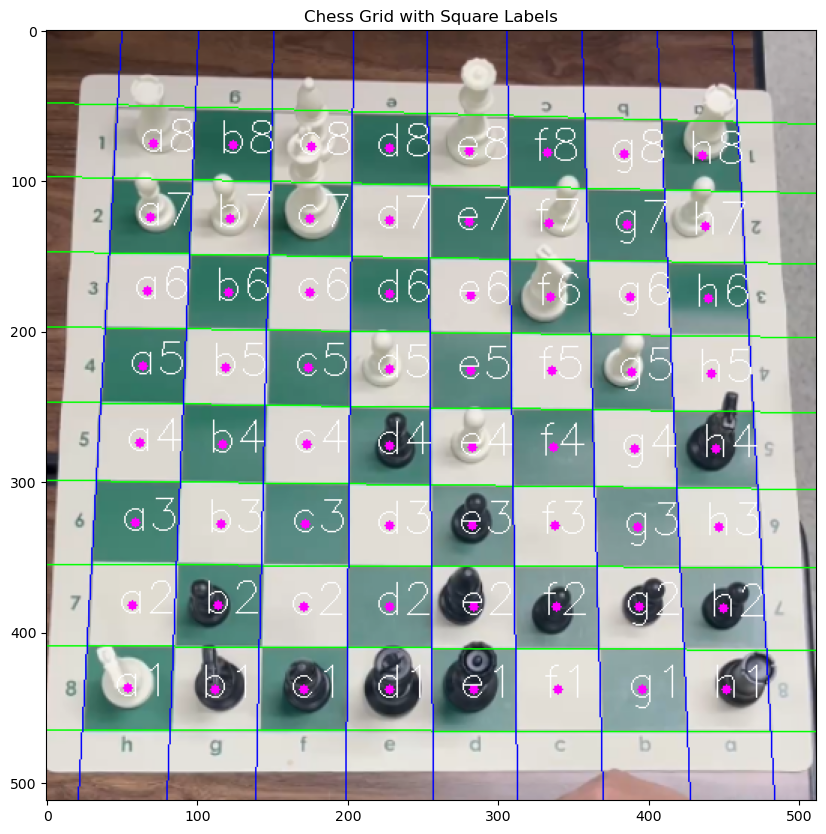


Grid created with 64 squares

Sample cell centers:
  a8: (71.7, 75.3)
  a1: (54.4, 437.9)
  h8: (436.0, 83.6)
  h1: (452.7, 438.8)


In [8]:
def get_line_intersections(lines_group1, lines_group2, unique_lines, img_shape):
    """Calculate intersection points between two groups of lines"""
    intersections = []
    
    for i in lines_group1:
        rho1, theta1 = unique_lines[i]
        for j in lines_group2:
            rho2, theta2 = unique_lines[j]
            
            # Calculate intersection using Cramer's rule
            # Line 1: x*cos(theta1) + y*sin(theta1) = rho1
            # Line 2: x*cos(theta2) + y*sin(theta2) = rho2
            
            cos1, sin1 = np.cos(theta1), np.sin(theta1)
            cos2, sin2 = np.cos(theta2), np.sin(theta2)
            
            det = cos1 * sin2 - sin1 * cos2
            
            if abs(det) > 1e-6:  # Lines not parallel
                x = (rho1 * sin2 - rho2 * sin1) / det
                y = (rho2 * cos1 - rho1 * cos2) / det
                
                # Check if intersection is within image bounds
                if 0 <= x < img_shape[1] and 0 <= y < img_shape[0]:
                    intersections.append((x, y))
    
    return intersections

def create_chess_grid(lines_group1, lines_group2, unique_lines, img_shape):
    """Create 8x8 chess grid from 9x9 line intersections"""
    
    # Sort lines by rho to get consistent ordering
    def get_sorted_lines(group_indices):
        lines_data = []
        for i in group_indices:
            rho, theta = unique_lines[i]
            if rho < 0:
                rho = -rho
                theta = theta + np.pi if theta < np.pi else theta - np.pi
            lines_data.append((i, rho, theta))
        lines_data.sort(key=lambda x: x[1])
        return [x[0] for x in lines_data]
    
    sorted_group1 = get_sorted_lines(lines_group1)
    sorted_group2 = get_sorted_lines(lines_group2)
    
    # Calculate all intersection points in order
    grid_points = np.zeros((9, 9, 2))
    
    for i, idx1 in enumerate(sorted_group1):
        for j, idx2 in enumerate(sorted_group2):
            rho1, theta1 = unique_lines[idx1]
            rho2, theta2 = unique_lines[idx2]
            
            cos1, sin1 = np.cos(theta1), np.sin(theta1)
            cos2, sin2 = np.cos(theta2), np.sin(theta2)
            
            det = cos1 * sin2 - sin1 * cos2
            
            if abs(det) > 1e-6:
                x = (rho1 * sin2 - rho2 * sin1) / det
                y = (rho2 * cos1 - rho1 * cos2) / det
                grid_points[i, j] = [x, y]
    
    return grid_points, sorted_group1, sorted_group2

def get_cell_centers(grid_points):
    """Calculate center points of 64 chess squares"""
    cell_centers = {}
    files = 'abcdefgh'
    ranks = '87654321'  # Top to bottom in image
    
    for row in range(8):
        for col in range(8):
            # Get 4 corners of the cell
            tl = grid_points[row, col]
            tr = grid_points[row, col + 1]
            bl = grid_points[row + 1, col]
            br = grid_points[row + 1, col + 1]
            
            # Calculate center
            center_x = (tl[0] + tr[0] + bl[0] + br[0]) / 4
            center_y = (tl[1] + tr[1] + bl[1] + br[1]) / 4
            
            # Map to chess notation
            square = files[col] + ranks[row]
            cell_centers[square] = {
                'center': (center_x, center_y),
                'corners': [tl, tr, br, bl]  # clockwise from top-left
            }
    
    return cell_centers

def point_in_cell(point, cell_data):
    """Check if a point is inside a cell using its corners"""
    px, py = point
    corners = cell_data['corners']
    
    # Use simple bounding box check (can be improved with polygon test)
    xs = [c[0] for c in corners]
    ys = [c[1] for c in corners]
    
    return min(xs) <= px <= max(xs) and min(ys) <= py <= max(ys)

def map_pieces_to_grid(yolo_results, cell_centers):
    """Map detected pieces to chess squares using bottom-center of bounding box"""
    board = {square: None for square in cell_centers.keys()}
    
    for box in yolo_results[0].boxes:
        # Get bounding box info
        x_center = float(box.xywh[0][0])
        y_center = float(box.xywh[0][1])
        width = float(box.xywh[0][2])
        height = float(box.xywh[0][3])
        
        # Calculate BOTTOM CENTER of bounding box (where piece actually sits)
        x_bottom_center = x_center
        y_bottom_center = y_center + (height / 2)
        
        class_id = int(box.cls[0])
        class_name = yolo_results[0].names[class_id]
        confidence = float(box.conf[0])
        
        # Find which square contains this piece
        for square, cell_data in cell_centers.items():
            if point_in_cell((x_bottom_center, y_bottom_center), cell_data):
                # Handle multiple detections: keep highest confidence
                if board[square] is not None:
                    print(f"Square {square} already has {board[square]['piece']} with confidence {board[square]['confidence']:.2f}. New piece: {class_name} with confidence {confidence:.2f}")
                if board[square] is None or confidence > board[square]['confidence']:
                    board[square] = {
                        'piece': class_name,
                        'confidence': confidence,
                        'position': (x_bottom_center, y_bottom_center),
                        'bbox_center': (x_center, y_center)  # Keep for visualization
                    }
                break
    
    return board

# Execute the pipeline
print("Creating chess grid from detected lines...")
grid_points, sorted_g1, sorted_g2 = create_chess_grid(
    best_group1, best_group2, unique_lines, img.shape
)

print("Calculating cell centers...")
cell_centers = get_cell_centers(grid_points)

# Visualize grid
canvas = img.copy()

# Draw grid lines
for i in sorted_g1:
    rho, theta = unique_lines[i]
    a, b = np.cos(theta), np.sin(theta)
    x0, y0 = a * rho, b * rho
    x1, y1 = int(x0 + 1000 * (-b)), int(y0 + 1000 * a)
    x2, y2 = int(x0 - 1000 * (-b)), int(y0 - 1000 * a)
    cv2.line(canvas, (x1, y1), (x2, y2), (0, 255, 0), 1)

for i in sorted_g2:
    rho, theta = unique_lines[i]
    a, b = np.cos(theta), np.sin(theta)
    x0, y0 = a * rho, b * rho
    x1, y1 = int(x0 + 1000 * (-b)), int(y0 + 1000 * a)
    x2, y2 = int(x0 - 1000 * (-b)), int(y0 - 1000 * a)
    cv2.line(canvas, (x1, y1), (x2, y2), (0, 0, 255), 1)

# Draw cell centers and labels
for square, cell_data in cell_centers.items():
    cx, cy = cell_data['center']
    cv2.circle(canvas, (int(cx), int(cy)), 3, (255, 0, 255), -1)
    cv2.putText(canvas, square, (int(cx)-10, int(cy)+5), 
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 1)

plt.figure(figsize=(10, 10))
plt.imshow(canvas)
plt.title('Chess Grid with Square Labels')
plt.show()

print(f"\nGrid created with {len(cell_centers)} squares")
print("\nSample cell centers:")
for square in ['a8', 'a1', 'h8', 'h1']:
    center = cell_centers[square]['center']
    print(f"  {square}: ({center[0]:.1f}, {center[1]:.1f})")

In [ ]:
from ultralytics import YOLO

model = YOLO("/home/anawat/JJ/Chula/Chess2PGN/weights/chess-piece/best(4).pt")

results = model(img)

# Map pieces to grid
print("Mapping detected pieces to chess squares...")
board_state = map_pieces_to_grid(results, cell_centers)

# Visualize result
canvas = img.copy()

# Draw grid
for i in sorted_g1:
    rho, theta = unique_lines[i]
    a, b = np.cos(theta), np.sin(theta)
    x0, y0 = a * rho, b * rho
    x1, y1 = int(x0 + 1000 * (-b)), int(y0 + 1000 * a)
    x2, y2 = int(x0 - 1000 * (-b)), int(y0 - 1000 * a)
    cv2.line(canvas, (x1, y1), (x2, y2), (100, 100, 100), 1)

for i in sorted_g2:
    rho, theta = unique_lines[i]
    a, b = np.cos(theta), np.sin(theta)
    x0, y0 = a * rho, b * rho
    x1, y1 = int(x0 + 1000 * (-b)), int(y0 + 1000 * a)
    x2, y2 = int(x0 - 1000 * (-b)), int(y0 - 1000 * a)
    cv2.line(canvas, (x1, y1), (x2, y2), (100, 100, 100), 1)

# Draw pieces with labels
for square, piece_data in board_state.items():
    if piece_data is not None:
        x, y = piece_data['position']
        piece_name = piece_data['piece']
        color = 'White' if piece_name[0].lower() == 'w' else 'Black'
        conf = piece_data['confidence']
        
        cv2.circle(canvas, (int(x), int(y)), 5, (0, 255, 0), -1)
        label = f"{square}:{color[0]+piece_name[5:]} ({conf:.2f})"
        cv2.putText(canvas, label, (int(x)-50, int(y)-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 255, 0), 1)

plt.figure(figsize=(10, 10))
plt.imshow(canvas)
plt.title('Pieces Mapped to Chess Squares')
plt.show()

# Print board state
print("\nBoard state:")
for rank in '87654321':
    for file in 'abcdefgh':
        square = file + rank
        piece = board_state[square]
        if piece:
            print(f"{square}: {piece['piece']} (conf: {piece['confidence']:.2f})")